In [20]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function

import os
import time

import numpy as np

from matplotlib import pylab as plt
import cv2

from scipy.misc import imsave
from scipy.optimize import fmin_l_bfgs_b

from keras.preprocessing.image import load_img, img_to_array

from keras import backend as K
from keras.layers import Input

import nm8brs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
base_image_path = os.path.join("data","devfest_gdg_300x300.jpg")
result_prefix = os.path.join("data","dream_devfest")

# dimensions of the generated picture.
img_width = 300
img_height = 300

# some settings we found interesting
saved_settings = {
    'math_trip': {'features': {'block3_conv': 0.01},
                 'continuity': 0.1,
                 'dream_l2': 0.1,
                 'jitter': 5},
}
# the settings we will use in this experiment
settings = saved_settings['math_trip']

In [47]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img = np.expand_dims(img, axis=2)
    img = np.expand_dims(img, axis=0)
    return img

def get_grey_image(image_path):
    img = load_img(image_path, target_size=(img_width, img_height))
    img = img_to_array(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return img

a = preprocess_image(base_image_path)

# util function to convert a tensor into a valid image
def deprocess_image(x):
    x = x.reshape((img_width, img_height))
    # Remove zero-center by mean pixel
    # 'BGR'->'RGB'
    x = x[:, :]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

img_size = (img_width, img_height, 1)
# this will contain our generated image
dream = Input(batch_shape=(1,) + img_size)

# build the VGG16 network with our placeholder
# the model will be loaded with pre-trained ImageNet weights
model = nm8brs.NM8RS(include_top=False,input_tensor=dream)

In [48]:
# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers])
# continuity loss util function
def continuity_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_width - 1, :img_height-1, :] -
                 x[:, 1:, :img_height - 1, :])
    b = K.square(x[:, :img_width - 1, :img_height-1, :] -
                 x[:, :img_width - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

# define the loss
loss = K.variable(0.)
for layer_name in settings['features']:
    # add the L2 norm of the features of a layer to the loss
    assert layer_name in layer_dict.keys(), 'Layer ' + layer_name + ' not found in model.'
    coeff = settings['features'][layer_name]
    x = layer_dict[layer_name].output
    shape = layer_dict[layer_name].output_shape
    # we avoid border artifacts by only involving non-border pixels in the loss
    loss -= coeff * K.sum(K.square(x[:, 2: shape[1] - 2, 2: shape[2] - 2, :])) / np.prod(shape[1:])

# add continuity loss (gives image local coherence, can result in an artful blur)
loss += settings['continuity'] * continuity_loss(dream) / np.prod(img_size)
# add image L2 norm to loss (prevents pixels from taking very high values, makes image darker)
loss += settings['dream_l2'] * K.sum(K.square(dream)) / np.prod(img_size)

# feel free to further modify the loss as you see fit, to achieve new effects...

# compute the gradients of the dream wrt the loss
grads = K.gradients(loss, dream)

outputs = [loss]
if type(grads) in {list, tuple}:
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([dream], outputs)
def eval_loss_and_grads(x):
    #print(x.shape)
    x = x.reshape((1,) + img_size)
    #print(x.shape)
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.
class Evaluator(object):
    def __init__(self):
        self.loss_value = None
        self.grad_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

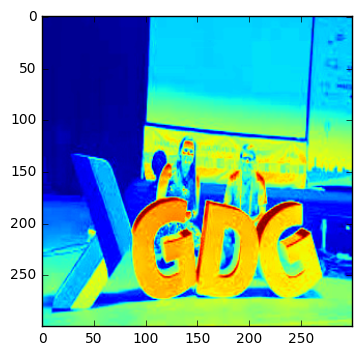

Start of iteration 0
Current loss value: 902.793


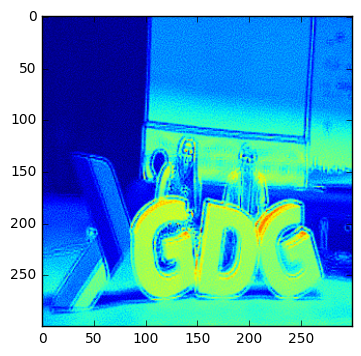

Iteration 0 completed in 2s
Start of iteration 1
Current loss value: 516.915


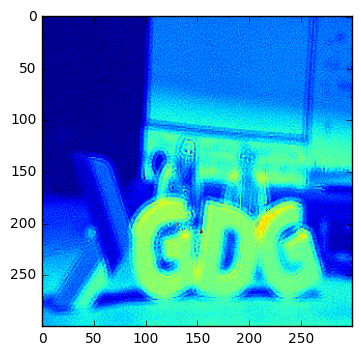

Iteration 1 completed in 1s
Start of iteration 2
Current loss value: 313.247


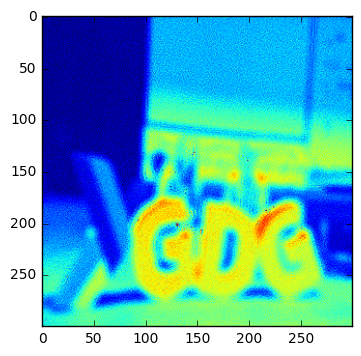

Iteration 2 completed in 1s
Start of iteration 3
Current loss value: 195.653


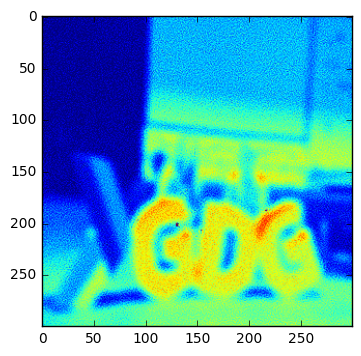

Iteration 3 completed in 1s
Start of iteration 4
Current loss value: 130.23


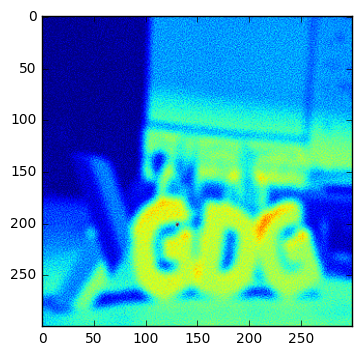

Iteration 4 completed in 1s
Start of iteration 5
Current loss value: 84.962


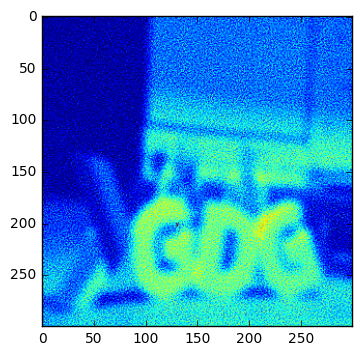

Iteration 5 completed in 1s
Start of iteration 6
Current loss value: 43.3561


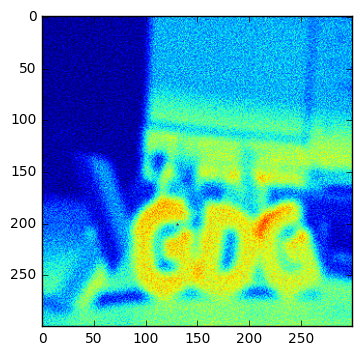

Iteration 6 completed in 1s
Start of iteration 7
Current loss value: 23.062


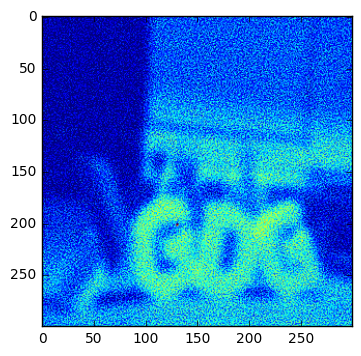

Iteration 7 completed in 1s
Start of iteration 8
Current loss value: 13.5509


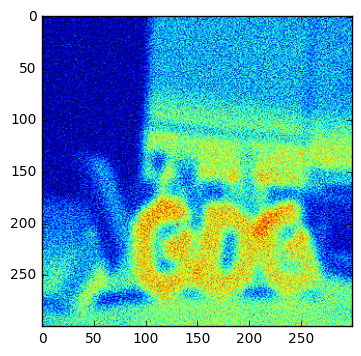

Iteration 8 completed in 1s
Start of iteration 9


KeyboardInterrupt: 

In [49]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the loss

im_grey = get_grey_image(base_image_path)
plt.imshow(im_grey)
plt.show()

x = preprocess_image(base_image_path)
for i in range(50):
    print('Start of iteration', i)
    start_time = time.time()

    # add a random jitter to the initial image. This will be reverted at decoding time
    random_jitter = (settings['jitter'] * 2) * (np.random.random(img_size) - 0.5)
    x += random_jitter

    # run L-BFGS for 7 steps
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=7)
    print('Current loss value:', min_val)
    # decode the dream and save it
    x = x.reshape(img_size)
    x -= random_jitter
    img = deprocess_image(np.copy(x))
    plt.imsave(os.path.join("results","deep_dream_nm8rs","iter_%s.jpg"%i),img)
    plt.imshow(img)
    plt.show()
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))